In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import HalvingGridSearchCV
from keras.callbacks import EarlyStopping
from functools import reduce

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

In [3]:
df = pd.read_csv('Raw_Data.csv',header=0).round(1)

In [4]:
#Original Data
df.head()

,%T254,%T215,Flow,UVS,Actual Power,N,RED
0,88.6,63.3,257.6,23.2,6.0,2,71.0
1,88.6,63.3,257.6,23.3,6.0,2,72.8
2,88.6,63.3,257.6,23.3,6.0,2,73.6
3,93.0,82.8,189.1,24.6,3.5,2,98.1
4,93.0,82.8,189.1,24.7,3.5,2,98.8


In [5]:
#Synthetic data for 1 and 2 lamps - based on UV dose multiplication
df1 = df.loc[df['N']==1].copy()
df1.loc[:, 'RED']*=2
df1.loc[:, 'N']=2

df2 = df.loc[df['N']==2].copy()
df2.loc[:, 'RED']/=2
df2.loc[:, 'N']=1

df=df.append(df1,ignore_index=True)
df=df.append(df2,ignore_index=True)

In [6]:
# Duplicate the situation for 3 and 4 lamps:
df_3 = df.loc[df['N']==1].copy()
df2.loc[:, 'RED']*=3
df2.loc[:, 'N']=3

df_4 = df.loc[df['N']==2].copy()
df2.loc[:, 'RED']*=2
df2.loc[:, 'N']=4

df=df.append(df_3,ignore_index=True)
df=df.append(df_4,ignore_index=True)

<AxesSubplot:xlabel='%T254', ylabel='%T215'>

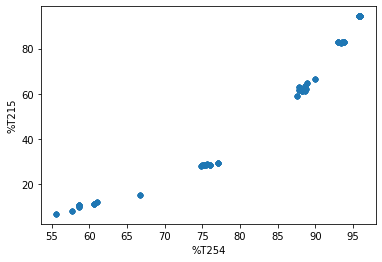

In [7]:
df.plot.scatter(x='%T254',y='%T215')

In [8]:
# Transform UVT into exp(-UVT/100)
df['%T254'] = np.exp(-df['%T254']/100)
df['%T215'] = np.exp(-df['%T215']/100)

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_features = sc.fit_transform(df.values)
#restore column names
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [10]:
X = scaled_features_df.drop('RED',axis=1)
y = scaled_features_df['RED']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

In [12]:
### HyperParameters:
Epochs = 100
Patience = 10

#Number of Features (may be worth to try PCA to reduce
Features = X_train.shape[1]

In [13]:
# Callbacks
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=Patience)
es = EarlyStopping(monitor='root_mean_squared_error', mode='min', verbose=1, patience=Patience)

In [14]:
### Experimental ###
def createModel(Dense1, Dense2, LearningRate, dropout, GNoise, L2regularization, Bias_regularization):
    model = Sequential()
    model.add(InputLayer(input_shape=(Features,)))
    model.add(GaussianNoise(GNoise))
    model.add(Dense(Dense1, kernel_regularizer=l2(L2regularization), bias_regularizer=l2(Bias_regularization), activation='softmax'))
    model.add(Dropout(dropout))
    model.add(Dense(Dense2, 'softmax'))
    model.add(Dense(1, 'linear'))
    #model1.summary()
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LearningRate), metrics=[RootMeanSquaredError()])
    return model

In [15]:
grid = dict(Dense1 = [6,7,8],
            Dense2 = [4,5,6],
            LearningRate = [0.005,0.01,0.02,0.03],
            dropout = [0.1],
            GNoise = [0.1],
            L2regularization = [0.005,0.01,0.02,0.05,0.1],
            Bias_regularization = [0.005,0.01,0.02,0.05,0.1]
            )

print('Total fits per parametric grid = {}'.format(reduce(lambda x, y: x*y, [len(grid[key]) for key in grid.keys()]))) # calculate number of test-parameters

estimator = KerasRegressor(build_fn=createModel)
modelGrid = GridSearchCV(estimator = estimator, param_grid = grid, cv=5, n_jobs=-1, verbose=2)
#modelGrid = HalvingGridSearchCV(estimator=estimator, param_grid=grid, cv=5, n_jobs=-1, verbose=2)
modelGrid.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=Epochs, callbacks=[es])

Total fits per parametric grid = 900
Fitting 5 folds for each of 900 candidates, totalling 4500 fits


C:\Users\Mike\anaconda3\envs\ML\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/100
6/6 [==============================] - 1s 97ms/step - loss: 1.2113 - root_mean_squared_error: 1.0845 - val_loss: 0.7983 - val_root_mean_squared_error: 0.8767
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 1.1039 - root_mean_squared_error: 1.0373 - val_loss: 0.7631 - val_root_mean_squared_error: 0.8584
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 1.0532 - root_mean_squared_error: 1.0130 - val_loss: 0.7441 - val_root_mean_squared_error: 0.8457
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 1.0100 - root_mean_squared_error: 0.9899 - val_loss: 0.6998 - val_root_mean_squared_error: 0.8165
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.9599 - root_mean_squared_error: 0.9618 - val_loss: 0.6362 - val_root_mean_squared_error: 0.7733
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.8982 - root_mean_squared_error: 0.9262 - val_loss: 0.5791 - val_root_mean_squared

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000016E8F1FB850>,
             n_jobs=-1,
             param_grid={'Bias_regularization': [0.005, 0.01, 0.02, 0.05, 0.1],
                         'Dense1': [6, 7, 8], 'Dense2': [4, 5, 6],
                         'GNoise': [0.1],
                         'L2regularization': [0.005, 0.01, 0.02, 0.05, 0.1],
                         'LearningRate': [0.005, 0.01, 0.02, 0.03],
                         'dropout': [0.1]},
             verbose=2)

In [16]:
#Evaluate the best model
print('best score = ',modelGrid.best_score_)
best_params = modelGrid.best_params_
print(best_params)

model1 = createModel(**best_params)
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=Epochs, callbacks=[es])

best score =  -0.25965909063816073
{'Bias_regularization': 0.02, 'Dense1': 8, 'Dense2': 6, 'GNoise': 0.1, 'L2regularization': 0.005, 'LearningRate': 0.02, 'dropout': 0.1}
Epoch 1/100
6/6 [==============================] - 0s 40ms/step - loss: 1.1621 - root_mean_squared_error: 1.0626 - val_loss: 0.7971 - val_root_mean_squared_error: 0.8772
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 1.1022 - root_mean_squared_error: 1.0372 - val_loss: 0.7837 - val_root_mean_squared_error: 0.8713
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 1.0538 - root_mean_squared_error: 1.0146 - val_loss: 0.7288 - val_root_mean_squared_error: 0.8387
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.9977 - root_mean_squared_error: 0.9855 - val_loss: 0.6576 - val_root_mean_squared_error: 0.7926
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.9038 - root_mean_squared_error: 0.9336 - val_loss: 0.6058 - val_root_mean_squar

In [17]:
pd.DataFrame(modelGrid.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Bias_regularization,param_Dense1,param_Dense2,param_GNoise,param_L2regularization,param_LearningRate,param_dropout,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
522,3.785777,0.463964,0.234386,0.071669,0.02,8,6,0.1,0.005,0.02,0.1,"{'Bias_regularization': 0.02, 'Dense1': 8, 'De...",-0.484128,-0.322640,-0.193319,-0.161260,-0.136948,-0.259659,0.129224,1
503,3.453796,0.510350,0.339580,0.230979,0.02,8,5,0.1,0.005,0.03,0.1,"{'Bias_regularization': 0.02, 'Dense1': 8, 'De...",-0.484185,-0.291210,-0.228598,-0.191292,-0.177370,-0.274531,0.111992,2
822,4.633782,0.751595,0.265587,0.098674,0.1,7,6,0.1,0.005,0.02,0.1,"{'Bias_regularization': 0.1, 'Dense1': 7, 'Den...",-0.548879,-0.294741,-0.218687,-0.171510,-0.140731,-0.274910,0.146498,3
362,4.190554,0.531723,0.231586,0.084191,0.02,6,4,0.1,0.005,0.02,0.1,"{'Bias_regularization': 0.02, 'Dense1': 6, 'De...",-0.533408,-0.282967,-0.224629,-0.201358,-0.137844,-0.276041,0.136824,4
162,4.426745,0.824619,0.311582,0.162268,0.005,8,6,0.1,0.005,0.02,0.1,"{'Bias_regularization': 0.005, 'Dense1': 8, 'D...",-0.580138,-0.274102,-0.183853,-0.153461,-0.192877,-0.276886,0.156790,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,5.099699,1.426549,0.379978,0.312905,0.05,7,5,0.1,0.1,0.005,0.1,"{'Bias_regularization': 0.05, 'Dense1': 7, 'De...",-1.260204,-1.499459,-0.309955,-0.323952,-0.354266,-0.749567,0.520338,896
476,4.769520,1.257472,0.204188,0.070123,0.02,7,6,0.1,0.1,0.005,0.1,"{'Bias_regularization': 0.02, 'Dense1': 7, 'De...",-1.254118,-1.469517,-0.339547,-0.405894,-0.287062,-0.751227,0.504584,897
716,4.790598,0.974739,0.234991,0.082299,0.05,8,6,0.1,0.1,0.005,0.1,"{'Bias_regularization': 0.05, 'Dense1': 8, 'De...",-1.314024,-1.445131,-0.357921,-0.408691,-0.300935,-0.765341,0.504387,898
619,3.409998,0.900408,0.254985,0.113475,0.05,7,4,0.1,0.1,0.03,0.1,"{'Bias_regularization': 0.05, 'Dense1': 7, 'De...",-1.985123,-0.667721,-0.680171,-0.306815,-0.221174,-0.772201,0.634158,899


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


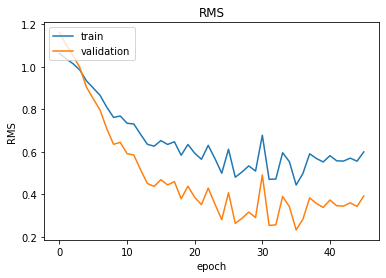

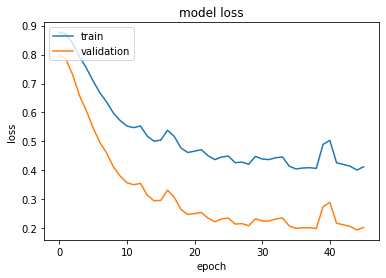

In [18]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['loss'])
plt.title('RMS')
plt.ylabel('RMS')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_root_mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
test_predictions = model1.predict(X_test)

In [20]:
X_test.insert(6,'RED',test_predictions)
y_pred = sc.inverse_transform(X_test)[:,Features]
X_test.drop('RED',axis=1).insert(Features,'RED',y_test)
y_test = sc.inverse_transform(X_test)[:,Features]

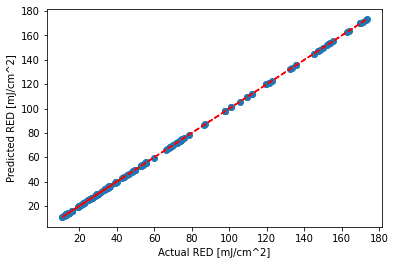

In [21]:
from numpy.polynomial.polynomial import polyfit
plt.scatter(y_test,y_pred)
# Fit with polyfit
b, m = polyfit(y_test, y_pred, 1)
plt.plot(y_test, b + m * y_test, '--', color='red')
plt.xlabel("Actual RED [mJ/cm^2]")
plt.ylabel("Predicted RED [mJ/cm^2]")
plt.show()

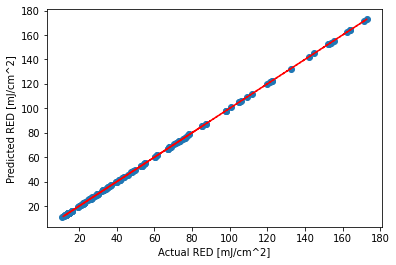

In [22]:
val_predictions = model1.predict(X_val)

X_val.insert(6,'RED',val_predictions)
y_pred = sc.inverse_transform(X_val)[:,Features]
X_val.drop('RED',axis=1).insert(Features,'RED',y_val)
y_val = sc.inverse_transform(X_val)[:,Features]

plt.scatter(y_val,y_pred)
# Fit with polyfit
b, m = polyfit(y_val, y_pred, 1)
plt.plot(y_val, b + m * y_val, '--', color='red')
plt.xlabel("Actual RED [mJ/cm^2]")
plt.ylabel("Predicted RED [mJ/cm^2]")
plt.show()

In [23]:
# Save model and scaler
from pickle import dump
model1.save('SavedModel_RED/REDmodel.h5')
#dump(model1, open('SavedModel_RED/REDmodel.pkl', 'wb'))
dump(sc, open('SavedModel_RED/scaler.pkl', 'wb'))

In [24]:
# Features format is as following:
# %T254,%T215,Flow,UVS,Actual Power,N,RED

# RED is the target

In [25]:
# Single testing point:
#88.6,63.3,257.6,23.18,6.0,2,70.98
#Target RED = 70.98

UVT254 = 88.6 # [%-1cm]
UVT215 = 63.3 # [%-1cm]
Flow = 258 # [m^3/hr]
UVS = 23.2 # [mJ/cm^2] - UV sensitivity aka D1Log
Power = 6 # [kW]
N_Lamps = 2

X_vector = sc.transform(pd.DataFrame([np.exp(-UVT254/100),np.exp(-UVT215/100),Flow,UVS,Power,N_Lamps,1]).T)[:,:Features]
# Dummy values added before the inverse transform due to the scaler preferences
RED = sc.inverse_transform([1,1,1,1,1,1,float(model1.predict(X_vector))])[Features]

In [26]:
print('RED = {}[mJ/cm^2]'.format(round(float(RED),1)))

RED = 77.4[mJ/cm^2]
